In [1]:
# %%
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pickle
import seaborn as sns

print('Libraries imported successfully!')
print(f'Using device: {torch.device("cuda" if torch.cuda.is_available() else "cpu")}')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Sklearn version: {np.__version__}')
print(f'Matplotlib version: {np.__version__}')
print(f'scipy version: {np.__version__}')
print(f'tqdm version: {np.__version__}')
print(f'pickle version: {np.__version__}')
print(f'pathlib version: {np.__version__}')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

############################
# Other Parameters
############################
MODEL_DIR = Path('model_weights_2')
info_path = MODEL_DIR / 'training_info.pkl'
csv_path = MODEL_DIR / 'test_results.csv'
txt_path = MODEL_DIR / 'test_results.txt'
png_path = MODEL_DIR / 'result.png'

distribution_png_path = MODEL_DIR / 'anomaly_score_distribution.png'
boxplot_png_path = MODEL_DIR / 'anomaly_score_boxplot.png'
precision_recall_png_path = MODEL_DIR / 'precision_recall_curve.png'
roc_curve_png_path = MODEL_DIR / 'roc_curve.png'
latent_pca_png_path = MODEL_DIR / 'latent_pca_plot.png'

WORKER_NODES = 20
ANOMALY_THRESHOLD = 0.5
MAX_GROUP_SIZE = 16


############################
# Hyperparameters
############################
FIRST_LAYER_HIDDEN_SIZE = 16
SECOND_LAYER_HIDDEN_SIZE = 128
LATENT_DIM_FIRST_LAYER = 16
LATENT_DIM_SECOND_LAYER = 32
CLUSTER_THRESHOLD = 0.6
BATCH_SIZE = 1024
EPOCHS_FIRST_LAYER = 3
EPOCHS_SECOND_LAYER = 8
LEARNING_RATE = 1e-4
MAX_GRAD_NORM = 5.0
CLAMP_LOGVAR_LOW = -10
CLAMP_LOGVAR_HIGH = 10

Libraries imported successfully!
Using device: cuda
Libraries imported successfully!
PyTorch version: 2.5.1
Pandas version: 2.2.3
Numpy version: 1.26.4
Sklearn version: 1.26.4
Matplotlib version: 1.26.4
scipy version: 1.26.4
tqdm version: 1.26.4
pickle version: 1.26.4
pathlib version: 1.26.4
Using device: cuda


In [2]:
############################
# Dataset Definitions
############################
class FirstLayerDataset(Dataset):
    def __init__(self, data, features):
        self.X = data[:, features]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].astype(np.float32)

class SecondLayerDataset(Dataset):
    def __init__(self, data):
        print("Initializing SecondLayerDataset...")
        if isinstance(data, np.ndarray):
            self.data = torch.from_numpy(data).float()
        elif isinstance(data, torch.Tensor):
            self.data = data.float()
        else:
            raise TypeError("Data should be a numpy array or a torch.Tensor.")
        print(f"Dataset initialized with {len(self)} samples.")

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index out of range.")
        return self.data[idx]

############################
# VAE Model Definition
############################
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.LeakyReLU(0.2)  # Using LeakyReLU

        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)

    def encode(self, x):
        h = self.activation(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, CLAMP_LOGVAR_LOW, CLAMP_LOGVAR_HIGH)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, logvar

    def decode(self, z):
        h = self.activation(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z, logvar = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    logvar = torch.clamp(logvar, CLAMP_LOGVAR_LOW, CLAMP_LOGVAR_HIGH)
    kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - torch.exp(logvar))
    return recon_loss + kld_loss



In [3]:
data = pd.read_csv('ARP_MitM_dataset.csv', header=None).values
labels = pd.read_csv('ARP_MitM_labels_Y.csv', header=None).values.flatten()

TRAIN_SIZE = 1_000_000
train_data = data[:TRAIN_SIZE]
train_labels = labels[:TRAIN_SIZE]
test_data = data[TRAIN_SIZE:]
test_labels = labels[TRAIN_SIZE:]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and test data
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)





Computing correlation matrix...
Converting correlation to distance...
Condensing distance matrix...
Performing hierarchical clustering...
Plotting dendrogram...


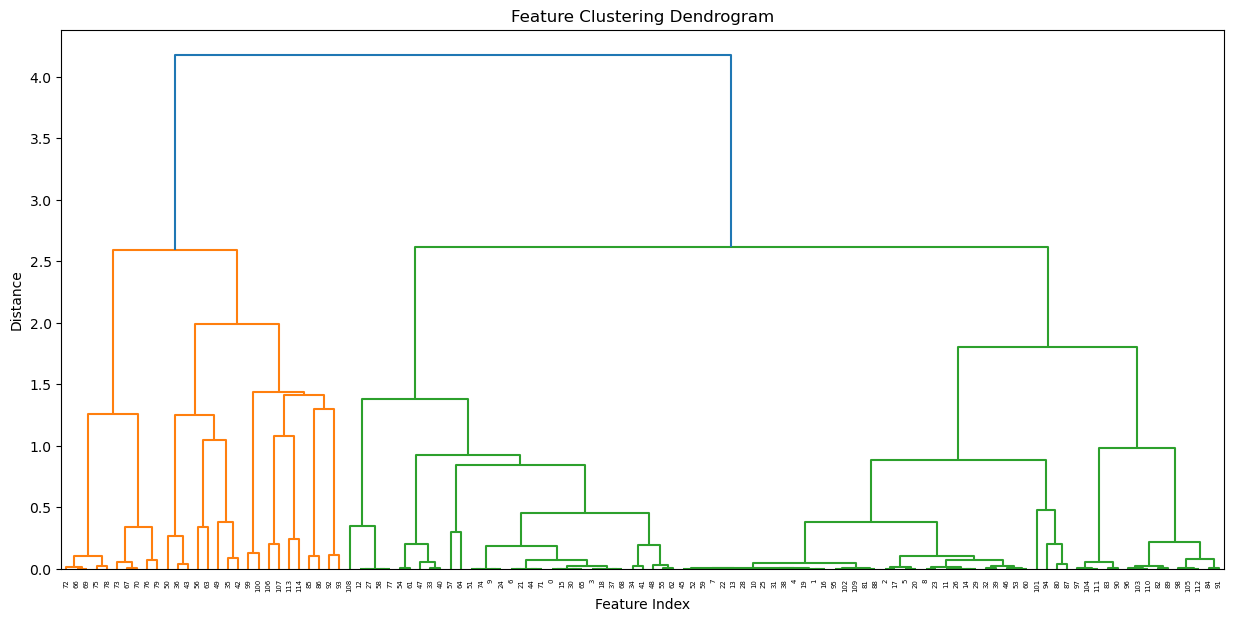

Assigning initial clusters with threshold 0.6...
Initial number of feature groups: 18
Group 0: [66, 69, 72, 75, 78]
Group 1: [67, 70, 73, 76, 79]
Group 2: [36, 43, 50]
Group 3: [56, 63]
Group 4: [35, 42, 49]
Group 5: [99, 100]
Group 6: [106, 107]
Group 7: [113, 114]
Group 8: [85, 86]
Group 9: [92, 93]
Group 10: [12, 27, 58, 77, 108]
Group 11: [33, 40, 47, 54, 61]
Group 12: [57, 64]
Group 13: [0, 3, 6, 9, 15, 18, 21, 24, 30, 34, 37, 41, 44, 48, 51, 55, 62, 65, 68, 71, 74]
Group 14: [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 38, 39, 45, 46, 52, 53, 59, 60, 81, 88, 95, 102, 109]
Group 15: [80, 87, 94, 101]
Group 16: [83, 90, 97, 104, 111]
Group 17: [82, 84, 89, 91, 96, 98, 103, 105, 110, 112]
Enforcing maximum group size of 16...
Group [0, 3, 6, 9, 15, 18, 21, 24, 30, 34, 37, 41, 44, 48, 51, 55, 62, 65, 68, 71, 74] exceeds maximum size of 16. Performing sub-clustering...
Splitting into 2 sub-clusters.
Group [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17,

In [4]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Define Maximum Group Size
# Function to determine hyperparameters based on group size
def get_hyperparameters(group_size):
    """
    Returns hidden_size and latent_dim based on the size of the feature group.
    """
    if group_size <= 4:
        hidden_size = 16
        latent_dim = 2
    elif 5 <= group_size <= 8:
        hidden_size = 32
        latent_dim = 4
    elif 9 <= group_size:
        hidden_size = 64
        latent_dim = 8

    return hidden_size, latent_dim
# Step 1: Compute Correlation Matrix Between Features
print("Computing correlation matrix...")
corr_matrix = np.corrcoef(train_data, rowvar=False)

# Step 2: Convert Correlation to Distance
print("Converting correlation to distance...")
distance_matrix = 1 - np.abs(corr_matrix)

# Step 3: Condense the Distance Matrix
print("Condensing distance matrix...")
condensed_distance = squareform(distance_matrix, checks=False)

# Step 4: Perform Hierarchical Clustering
print("Performing hierarchical clustering...")
Z = linkage(condensed_distance, method='ward')  # 'ward' linkage is appropriate here

# Step 5: Visualize the Dendrogram (Optional)
print("Plotting dendrogram...")
plt.figure(figsize=(15, 7))
dendrogram(Z, labels=range(len(corr_matrix)), leaf_rotation=90)
plt.title('Feature Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
plt.show()

# Step 6: Assign Initial Cluster Labels
# Decide on a threshold based on dendrogram analysis
initial_threshold = 0.6  # Example threshold; adjust based on your dendrogram
print(f"Assigning initial clusters with threshold {initial_threshold}...")
cluster_assignments = fcluster(Z, t=initial_threshold, criterion='distance')

# Create initial feature groups based on cluster assignments
feature_groups_dict = {}
for idx, cluster_id in enumerate(cluster_assignments):
    if cluster_id not in feature_groups_dict:
        feature_groups_dict[cluster_id] = []
    feature_groups_dict[cluster_id].append(idx)

feature_groups = [feature_groups_dict[key] for key in sorted(feature_groups_dict.keys())]
print(f'Initial number of feature groups: {len(feature_groups)}')
for idx, group in enumerate(feature_groups):
    print(f'Group {idx}: {group}')

# Step 7: Enforce Maximum Group Size with Sub-Clustering
from math import ceil

def enforce_max_group_size(feature_groups, train_data, max_size, distance_metric='euclidean', linkage_method='ward', sub_threshold=0.5):
    """
    Splits feature groups that exceed the maximum size by performing sub-clustering.
    
    Parameters:
    - feature_groups: List of feature groups (each group is a list of feature indices)
    - train_data: Original training data (numpy array)
    - max_size: Maximum allowed number of features per group
    - distance_metric: Distance metric for sub-clustering
    - linkage_method: Linkage method for sub-clustering
    - sub_threshold: Distance threshold for sub-clustering
    
    Returns:
    - new_feature_groups: List of feature groups with sizes <= max_size
    """
    new_feature_groups = []
    for group in feature_groups:
        if len(group) <= max_size:
            new_feature_groups.append(group)
        else:
            print(f"Group {group} exceeds maximum size of {max_size}. Performing sub-clustering...")
            # Calculate the number of sub-clusters needed
            num_subclusters = ceil(len(group) / max_size)
            print(f"Splitting into {num_subclusters} sub-clusters.")
            
            # Extract the sub-data for the current group
            sub_data = train_data[:, group]
            
            # Compute correlation distance for the sub-group
            sub_corr_matrix = np.corrcoef(sub_data, rowvar=False)
            sub_distance_matrix = 1 - np.abs(sub_corr_matrix)
            
            # Condense the distance matrix
            sub_condensed_distance = squareform(sub_distance_matrix, checks=False)
            
            # Handle cases where all features are identical or highly correlated
            if np.all(sub_distance_matrix == 0):
                # All features are identical; split into equal-sized groups
                split_indices = np.array_split(group, num_subclusters)
                for sub_group in split_indices:
                    new_feature_groups.append(list(sub_group))
                continue
            
            # Perform hierarchical clustering on the sub-group
            Z_sub = linkage(sub_condensed_distance, method=linkage_method)
            
            # Assign sub-cluster labels based on the required number of sub-clusters
            sub_cluster_assignments = fcluster(Z_sub, t=num_subclusters, criterion='maxclust')
            
            # Create sub-feature groups
            sub_feature_groups_dict = {}
            for idx_sub, sub_cluster_id in enumerate(sub_cluster_assignments):
                if sub_cluster_id not in sub_feature_groups_dict:
                    sub_feature_groups_dict[sub_cluster_id] = []
                sub_feature_groups_dict[sub_cluster_id].append(group[idx_sub])
            
            # Append the sub-groups to the new_feature_groups
            for sub_group in sub_feature_groups_dict.values():
                if len(sub_group) > max_size:
                    print(f"Sub-group {sub_group} still exceeds maximum size. Recursively splitting...")
                    # Recursive call to handle further splitting
                    smaller_sub_groups = enforce_max_group_size([sub_group], train_data, max_size, distance_metric, linkage_method, sub_threshold)
                    new_feature_groups.extend(smaller_sub_groups)
                else:
                    new_feature_groups.append(sub_group)
    return new_feature_groups

# Apply the enforcement of maximum group size
print(f"Enforcing maximum group size of {MAX_GROUP_SIZE}...")
final_feature_groups = enforce_max_group_size(feature_groups, train_data_scaled, MAX_GROUP_SIZE)
print(f'Final number of feature groups: {len(final_feature_groups)}')
for idx, group in enumerate(final_feature_groups):
    print(f'Group {idx}: {group}')


In [5]:
############################
# Train First-Layer VAEs
############################
def all_vae_weights_exist(num_vaes):
    for idx in range(num_vaes):
        vae_path = MODEL_DIR / f'first_layer_vae_{idx}.pth'
        if not vae_path.is_file():
            return False
    return True

os.makedirs(MODEL_DIR, exist_ok=True)

first_layer_vaes = []
info_dict = {
    'feature_groups': final_feature_groups,
    'scaler': scaler,
    'train_size': TRAIN_SIZE,
    'input_dim': data.shape[1],
    'first_layer_hyperparameters': [],  # List to store (hidden_size, latent_dim) tuples
}

if MODEL_DIR.is_dir() and info_path.is_file():
    with open(info_path, 'rb') as f:
        saved_info = pickle.load(f)
    saved_feature_groups = saved_info['feature_groups']
    saved_scaler = saved_info['scaler']
    saved_hyperparameters = saved_info['first_layer_hyperparameters']
    
    if all_vae_weights_exist(len(saved_feature_groups)):
        print("Found existing first-layer VAEs, loading them...")
        for idx, (features, hyperparams) in enumerate(zip(saved_feature_groups, saved_hyperparameters)):
            hidden_size, latent_dim = hyperparams
            input_dim = len(features)
            vae = VAE(input_dim, hidden_size, latent_dim).to(DEVICE)
            vae.load_state_dict(torch.load(MODEL_DIR / f'first_layer_vae_{idx}.pth', map_location=DEVICE))
            vae.eval()
            first_layer_vaes.append(vae)
        feature_groups = saved_feature_groups
        scaler = saved_scaler
    else:
        print("VAE weights are missing. Retraining first-layer VAEs...")
        # Retrain first-layer VAEs
        first_layer_vaes = []
        info_dict['first_layer_hyperparameters'] = []
        for idx, features in enumerate(saved_feature_groups):
            input_dim = len(features)
            hidden_size, latent_dim = get_hyperparameters(input_dim)
            vae = VAE(input_dim, hidden_size, latent_dim).to(DEVICE)
            optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
    
            train_dataset = FirstLayerDataset(train_data_scaled, features)
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
            vae.train()
            for epoch in range(EPOCHS_FIRST_LAYER):
                total_loss = 0
                for batch in train_loader:
                    batch = batch.to(DEVICE)
                    optimizer.zero_grad()
                    recon_x, mu, logvar = vae(batch)
                    loss = vae_loss(recon_x, batch, mu, logvar)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(vae.parameters(), MAX_GRAD_NORM)
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(train_loader.dataset)
                print(f'First Layer VAE {idx+1}/{len(saved_feature_groups)} Epoch [{epoch+1}/{EPOCHS_FIRST_LAYER}] Loss: {avg_loss:.4f}')
    
            vae.eval()
            first_layer_vaes.append(vae)
            hidden_size, latent_dim = get_hyperparameters(input_dim)
            info_dict['first_layer_hyperparameters'].append((hidden_size, latent_dim))
    
            # Save the trained VAE
            vae_path = MODEL_DIR / f'first_layer_vae_{idx}.pth'
            torch.save(vae.state_dict(), vae_path)
            print(f"Saved {vae_path}")
    
        # Save the updated info_dict
        with open(info_path, 'wb') as f:
            pickle.dump(info_dict, f)
        print("Saved feature groups, scaler, and configuration info.")
else:
    # No existing model or info, train from scratch
    print("No existing models found, training first-layer VAEs...")
    first_layer_vaes = []
    info_dict['first_layer_hyperparameters'] = []
    
    for idx, features in enumerate(final_feature_groups):
        input_dim = len(features)
        hidden_size, latent_dim = get_hyperparameters(input_dim)
        vae = VAE(input_dim, hidden_size, latent_dim).to(DEVICE)
        optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
    
        train_dataset = FirstLayerDataset(train_data_scaled, features)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        vae.train()
        for epoch in range(EPOCHS_FIRST_LAYER):
            total_loss = 0
            for batch in train_loader:
                batch = batch.to(DEVICE)
                optimizer.zero_grad()
                recon_x, mu, logvar = vae(batch)
                loss = vae_loss(recon_x, batch, mu, logvar)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(vae.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader.dataset)
            print(f'First Layer VAE {idx+1}/{len(final_feature_groups)} Epoch [{epoch+1}/{EPOCHS_FIRST_LAYER}] Loss: {avg_loss:.4f}')
    
        vae.eval()
        first_layer_vaes.append(vae)
        hidden_size, latent_dim = get_hyperparameters(input_dim)
        info_dict['first_layer_hyperparameters'].append((hidden_size, latent_dim))
    
        # Save the trained VAE
        vae_path = MODEL_DIR / f'first_layer_vae_{idx}.pth'
        torch.save(vae.state_dict(), vae_path)
        print(f"Saved {vae_path}")
    
    # Save the updated info_dict
    with open(info_path, 'wb') as f:
        pickle.dump(info_dict, f)
    print("Saved feature groups, scaler, and configuration info.")
# first_layer_vaes now loaded or trained and ready for next steps

Found existing first-layer VAEs, loading them...


C:\Users\Simon Ulloa\AppData\Local\Temp\ipykernel_33188\597618704.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(MODEL_DIR / f'first_lay

In [6]:
############################
# Compute Training Error Vectors for Second-Layer Input (Batch Processing)
############################

from concurrent.futures import ThreadPoolExecutor, as_completed
import time


def process_sample_errors(sample, vaes, groups, device):
    start_time = time.time()
    sample_errors = []
    try:
        with torch.no_grad():
            for vae, features in zip(vaes, groups):
                x_sub = torch.tensor(sample[features], dtype=torch.float32, device=device).unsqueeze(0)
                recon_x, mu, logvar = vae(x_sub)
                mse_error = nn.functional.mse_loss(recon_x, x_sub, reduction='mean').item()
                sample_errors.append(mse_error)
    except Exception as e:
        print(f"Error: {e}")
    finally:
        print(f"Sample processed in {time.time() - start_time:.4f} seconds")
    return sample_errors

def compute_subspace_errors(data, vaes, groups, device=DEVICE, max_workers=WORKER_NODES):
    errors = [None] * len(data)
    completed = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_sample_errors, data[i], vaes, groups, device): i
            for i in range(len(data))
        }

        for future in as_completed(futures):
            i = futures[future]
            errors[i] = future.result()
            completed += 1
            tqdm.write(f"Completed {completed}/{len(data)} samples")

    return np.array(errors)


train_errors_path = MODEL_DIR / 'train_subspace_errors.npy'
if train_errors_path.is_file():
    print(f"Found {train_errors_path}, loading subspace errors...")
    train_subspace_errors = np.load(train_errors_path)
else:
    print("Computing subspace errors for training data (multithreaded)...")
    train_subspace_errors = compute_subspace_errors(train_data, first_layer_vaes, feature_groups, device=DEVICE, max_workers=WORKER_NODES)
    np.save(train_errors_path, train_subspace_errors)
    print(f"Saved subspace errors to {train_errors_path}")

# Normalize errors for second-layer training
min_errors = train_subspace_errors.min(axis=0)
max_errors = train_subspace_errors.max(axis=0)

# Avoid division by zero if max == min
max_errors = np.where(max_errors == min_errors, min_errors+1e-6, max_errors)

train_normalized_errors = (train_subspace_errors - min_errors) / (max_errors - min_errors)

second_layer_input_dim = train_normalized_errors.shape[1]

second_dataset = SecondLayerDataset(train_normalized_errors)
second_loader = DataLoader(second_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Found model_weights_2\train_subspace_errors.npy, loading subspace errors...
Initializing SecondLayerDataset...
Dataset initialized with 1000000 samples.


In [7]:
try:
    for i, batch in enumerate(second_loader):
        print(f"Batch {i+1} shape: {batch.shape}")
        if i >= 2:  # Check first 3 batches
            break
except Exception as e:
    print(f"DataLoader encountered an error: {e}")

Batch 1 shape: torch.Size([1024, 22])
Batch 2 shape: torch.Size([1024, 22])
Batch 3 shape: torch.Size([1024, 22])


In [8]:
############################
# Train Second-Layer VAE on Normalized Error Vectors with Progress Feedback
############################
second_layer_vae = VAE(second_layer_input_dim, SECOND_LAYER_HIDDEN_SIZE, LATENT_DIM_SECOND_LAYER).to(DEVICE)
second_optimizer = torch.optim.Adam(second_layer_vae.parameters(), lr=LEARNING_RATE)

second_layer_vae.train()
for epoch in range(EPOCHS_SECOND_LAYER):
    total_loss = 0
    # Initialize tqdm progress bar for batches within the current epoch
    batch_iterator = tqdm(second_loader, desc=f'Epoch {epoch+1}/{EPOCHS_SECOND_LAYER}', unit='batch')
    
    for i, batch in enumerate(batch_iterator):
        batch = batch.to(DEVICE)
        second_optimizer.zero_grad()
        recon_x, mu, logvar = second_layer_vae(batch)
        loss = vae_loss(recon_x, batch, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(second_layer_vae.parameters(), MAX_GRAD_NORM)
        second_optimizer.step()
        total_loss += loss.item()
        
        # Update the progress bar with the current batch loss
        batch_iterator.set_postfix(loss=f"{loss.item():.4f}")
    
    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(second_loader)
    print(f'Second Layer Epoch [{epoch+1}/{EPOCHS_SECOND_LAYER}] Average Loss: {avg_loss:.4f}')

second_layer_vae.eval()

Epoch 1/8: 100%|██████████| 977/977 [00:07<00:00, 130.74batch/s, loss=0.0437]


Second Layer Epoch [1/8] Average Loss: 0.1362


Epoch 2/8: 100%|██████████| 977/977 [00:07<00:00, 129.20batch/s, loss=0.0310]


Second Layer Epoch [2/8] Average Loss: 0.0369


Epoch 3/8: 100%|██████████| 977/977 [00:07<00:00, 132.19batch/s, loss=0.0262]


Second Layer Epoch [3/8] Average Loss: 0.0281


Epoch 4/8: 100%|██████████| 977/977 [00:07<00:00, 128.59batch/s, loss=0.0211]


Second Layer Epoch [4/8] Average Loss: 0.0238


Epoch 5/8: 100%|██████████| 977/977 [00:07<00:00, 130.28batch/s, loss=0.0203]


Second Layer Epoch [5/8] Average Loss: 0.0216


Epoch 6/8: 100%|██████████| 977/977 [00:07<00:00, 132.40batch/s, loss=0.0199]


Second Layer Epoch [6/8] Average Loss: 0.0206


Epoch 7/8: 100%|██████████| 977/977 [00:07<00:00, 129.00batch/s, loss=0.0202]


Second Layer Epoch [7/8] Average Loss: 0.0201


Epoch 8/8: 100%|██████████| 977/977 [00:07<00:00, 128.05batch/s, loss=0.0200]

Second Layer Epoch [8/8] Average Loss: 0.0198


VAE(
  (fc1): Linear(in_features=22, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=22, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)

In [9]:
############################
# Anomaly Scoring on Test Data
############################
# Define a dataset for test data
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Modify get_test_subspace_errors to use batching
def get_test_subspace_errors(data, vaes, groups, min_err, max_err, batch_size=1024, num_workers=0):
    errors = []
    test_dataset = TestDataset(data)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    total_batches = len(test_loader)
    for batch_idx, batch_samples in enumerate(test_loader):
        # Print progress every 10 batches
        if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
            print(f"Processing batch {batch_idx + 1}/{total_batches}")
        
        batch_errors = []
        with torch.no_grad():
            for vae, features in zip(vaes, groups):
                x_sub = torch.tensor(batch_samples[:, features], dtype=torch.float32, device=DEVICE)
                recon_x, mu, logvar = vae(x_sub)
                mse_error = nn.functional.mse_loss(recon_x, x_sub, reduction='none').mean(dim=1)
                batch_errors.append(mse_error.cpu().numpy())
        batch_errors = np.stack(batch_errors, axis=1)
        errors.append(batch_errors)
    
    errors = np.concatenate(errors, axis=0)
    errors = (errors - min_err) / (max_err - min_err)
    errors = np.clip(errors, 0, 1)
    return errors

def compute_final_anomaly_scores(test_subspace_errors, second_layer_vae, batch_size=1024, num_workers=0):
    test_dataset = TestDataset(test_subspace_errors)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    total_batches = len(test_loader)
    test_scores = []
    with torch.no_grad():
        for batch_idx, error_vec_batch in enumerate(test_loader):
            # Print progress every 10 batches
            if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
                print(f"Scoring batch {batch_idx + 1}/{total_batches}")
            
            error_vec_batch = torch.tensor(error_vec_batch, dtype=torch.float32, device=DEVICE)
            recon_x, mu, logvar = second_layer_vae(error_vec_batch)
            mse_error = nn.functional.mse_loss(recon_x, error_vec_batch, reduction='none').mean(dim=1)
            test_scores.extend(mse_error.cpu().numpy())
    return np.array(test_scores)

# Use the modified functions
test_errors_path = MODEL_DIR / 'test_subspace_errors.npy'
if test_errors_path.is_file():
    print(f"Found {test_errors_path}, loading test subspace errors...")
    test_subspace_errors = np.load(test_errors_path)
else:
    test_subspace_errors = get_test_subspace_errors(test_data, first_layer_vaes, feature_groups, min_errors, max_errors)
    np.save(test_errors_path, test_subspace_errors)
    print(f"Saved test subspace errors to {test_errors_path}")

test_scores_path = MODEL_DIR / 'test_results.csv'
if test_scores_path.is_file():
    print(f"Found {test_scores_path}, loading test_scores from disk...")
    test_scores = np.loadtxt(test_scores_path, delimiter=',')
else:
    print("Computing final anomaly scores from second-layer VAE...")
    test_scores = compute_final_anomaly_scores(test_subspace_errors, second_layer_vae)
    np.savetxt(test_scores_path, test_scores, delimiter=',')
    print(f"Test scores saved to {test_scores_path}")

: 

In [ ]:
############################
# Visualization and Metric Computation
############################
normal_scores = test_scores[test_labels == 0]
malicious_scores = test_scores[test_labels == 1]

# Plot Histograms
plt.figure(figsize=(10,6))
sns.histplot(normal_scores, bins=100, color='blue', alpha=0.5, label='Normal', kde=True)
sns.histplot(malicious_scores, bins=100, color='red', alpha=0.5, label='Malicious', kde=True)
plt.axvline(x=ANOMALY_THRESHOLD, color='green', linestyle='--', label=f'Threshold: {ANOMALY_THRESHOLD:.4f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Number of Packets')
plt.title('Distribution of Anomaly Scores for Test Packets')
plt.legend()
plt.tight_layout()
plt.savefig(distribution_png_path)
plt.close()
print(f"Anomaly score distribution plot saved to '{distribution_png_path}'")

df_scores = pd.DataFrame({
    'Anomaly Score': test_scores,
    'Label': ['Normal' if label == 0 else 'Malicious' for label in test_labels]
})

plt.figure(figsize=(8,6))
sns.boxplot(x='Label', y='Anomaly Score', data=df_scores, palette={'Normal': 'blue', 'Malicious': 'red'})
plt.title('Boxplot of Anomaly Scores by Label')
plt.tight_layout()
plt.savefig(boxplot_png_path)
plt.close()
print(f"Anomaly score boxplot saved to '{boxplot_png_path}'")

if not os.path.exists(txt_path) and not os.path.exists(png_path):
    print("Computing metrics and generating plot since neither test_results.txt nor result.png exist...")
    
    # Find best threshold via F1-score on test set
    thresholds = np.linspace(np.min(test_scores), np.max(test_scores), num=1000)
    best_f1 = -1
    best_threshold = ANOMALY_THRESHOLD

    # for threshold in thresholds:
    #     y_pred = (test_scores >= threshold).astype(int)
    #     f1_val = f1_score(test_labels, y_pred, zero_division=0)
    #     if f1_val > best_f1:
    #         best_f1 = f1_val
    #         best_threshold = threshold

    ANOMALY_THRESHOLD = 0.15
    print(f"Optimal Anomaly Threshold based on F1-score: {ANOMALY_THRESHOLD:.4f}")
    print(f"Best F1-score: {best_f1:.4f}")

    y_pred = (test_scores >= ANOMALY_THRESHOLD).astype(int)

    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred, zero_division=0)
    rec = recall_score(test_labels, y_pred, zero_division=0)
    f1 = f1_score(test_labels, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0

    with open(txt_path, 'w') as f:
        f.write("Model Parameters:\n")
        f.write(f"FIRST_LAYER_HIDDEN_SIZE: {FIRST_LAYER_HIDDEN_SIZE}\n")
        f.write(f"SECOND_LAYER_HIDDEN_SIZE: {SECOND_LAYER_HIDDEN_SIZE}\n")
        f.write(f"LATENT_DIM_FIRST_LAYER: {LATENT_DIM_FIRST_LAYER}\n")
        f.write(f"LATENT_DIM_SECOND_LAYER: {LATENT_DIM_SECOND_LAYER}\n")
        f.write(f"CLUSTER_THRESHOLD: {CLUSTER_THRESHOLD}\n")
        f.write(f"BATCH_SIZE: {BATCH_SIZE}\n")
        f.write(f"EPOCHS_FIRST_LAYER: {EPOCHS_FIRST_LAYER}\n")
        f.write(f"EPOCHS_SECOND_LAYER: {EPOCHS_SECOND_LAYER}\n")
        f.write(f"LEARNING_RATE: {LEARNING_RATE}\n")
        f.write(f"MAX_GRAD_NORM: {MAX_GRAD_NORM}\n")
        f.write(f"CLAMP_LOGVAR_LOW: {CLAMP_LOGVAR_LOW}\n")
        f.write(f"CLAMP_LOGVAR_HIGH: {CLAMP_LOGVAR_HIGH}\n")
        f.write("\nMetrics:\n")
        f.write(f"Anomaly Threshold: {ANOMALY_THRESHOLD}\n")
        f.write(f"Number of Test Packets: {len(test_labels)}\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Precision: {prec:.4f}\n")
        f.write(f"Recall: {rec:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"True Positive Rate (TPR): {tpr:.4f}\n")
        f.write(f"False Negative Rate (FNR): {fnr:.4f}\n")
    print(f"Metrics saved to '{txt_path}'")

    # Plot final results with updated threshold
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(len(test_scores))[test_labels==0], test_scores[test_labels==0], s=1, c='blue', label='Normal')
    plt.scatter(np.arange(len(test_scores))[test_labels==1], test_scores[test_labels==1], s=1, c='red', label='Malicious')
    plt.axhline(y=ANOMALY_THRESHOLD, color='green', linestyle='--', label=f'Threshold: {ANOMALY_THRESHOLD:.4f}')
    plt.xlabel('Packet Index (Test Set)')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Scores on Test Packets')
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path)
    plt.close()
    print(f"Plot saved to '{png_path}'")

    # Precision-Recall Curve
    precision_vals, recall_vals, pr_thresholds = precision_recall_curve(test_labels, test_scores)
    f1_vals = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    best_pr_idx = np.argmax(f1_vals)
    best_pr_threshold = pr_thresholds[best_pr_idx]
    best_pr_f1 = f1_vals[best_pr_idx]

    plt.figure(figsize=(10,6))
    plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
    plt.scatter(recall_vals[best_pr_idx], precision_vals[best_pr_idx], color='red',
                label=f'Best Threshold: {best_pr_threshold:.4f}\nF1-score: {best_pr_f1:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(precision_recall_png_path)
    plt.close()
    print(f"Precision-Recall curve saved to '{precision_recall_png_path}'")

    # ROC Curve
    fpr_vals, tpr_vals, roc_thresholds = roc_curve(test_labels, test_scores)
    roc_auc = roc_auc_score(test_labels, test_scores)
    distances = np.sqrt((1 - tpr_vals)**2 + fpr_vals**2)
    best_roc_idx = np.argmin(distances)
    best_roc_threshold = roc_thresholds[best_roc_idx]

    plt.figure(figsize=(10,6))
    plt.plot(fpr_vals, tpr_vals, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.scatter(fpr_vals[best_roc_idx], tpr_vals[best_roc_idx], color='red',
                label=f'Best Threshold: {best_roc_threshold:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(roc_curve_png_path)
    plt.close()
    print(f"ROC curve saved to '{roc_curve_png_path}'")

    # PCA Plot on error vectors (Optional)
    # Already computed: we have train_normalized_errors as input
    # If you want, visualize train_normalized_errors with PCA or test data error distributions

else:
    print("Not updating metrics or plot because test_results.txt or result.png (or both) already exist.")
